Name: Soham Bhattacharya <br>
Roll.No.: B2430059

# Lab-03
<h3>Aim: Render cube on a chessboard image</h3>

## Importing necessary libraries

In [68]:
# Importing necessary packages

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import cv2 as cv
import glob

## Rendering a cube on a virtual chessboard

In [69]:
# Function to create a 3D chessboard
def plot_chessboard(ax):
    board_size = 8
    for i in range(board_size):
        for j in range(board_size):
            color = 'white' if (i + j) % 2 == 0 else 'black'
            square = [
                (i, j, 0),
                (i+1, j, 0),
                (i+1, j+1, 0),
                (i, j+1, 0)
            ]
            ax.add_collection3d(Poly3DCollection([square], color=color, alpha=0.8))

In [70]:
# Function to render a cube on the chessboard
def render_cube_on_chessboard():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    plot_chessboard(ax)

    cube_vertices = np.array([
        [2, 2, 0], [4, 2, 0], [4, 4, 0], [2, 4, 0],  # Bottom square
        [2, 2, 1], [4, 2, 1], [4, 4, 1], [2, 4, 1]   # Top square
    ])

    cube_faces = [
        [cube_vertices[i] for i in [0, 1, 2, 3]],  # Bottom
        [cube_vertices[i] for i in [4, 5, 6, 7]],  # Top
        [cube_vertices[i] for i in [0, 1, 5, 4]],  # Front
        [cube_vertices[i] for i in [2, 3, 7, 6]],  # Back
        [cube_vertices[i] for i in [1, 2, 6, 5]],  # Right
        [cube_vertices[i] for i in [0, 3, 7, 4]]   # Left
    ]

    ax.add_collection3d(Poly3DCollection(cube_faces, color='red', alpha=0.6))

    ax.set_xlim([0, 8])
    ax.set_ylim([0, 8])
    ax.set_zlim([0, 3])

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

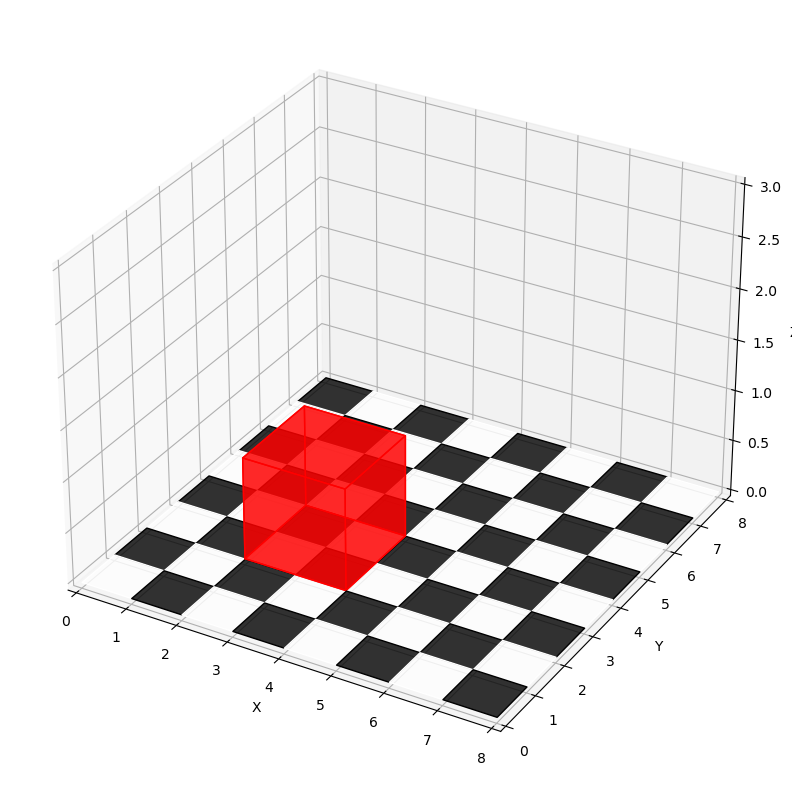

In [71]:
render_cube_on_chessboard()

## Pose Estimation: Rendering a cube on a chessboard image

In [72]:
chessboard_size = (7, 7)  
square_size = 2.5

In [73]:
# Preparing object points (0,0,0), (1,0,0), (2,0,0) ... (6,6,0)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp *= square_size

In [74]:
# Arrays to store object points and image points
objpoints = []  # 3D points in real-world space
imgpoints = []  # 2D points in image plane

### Detecting Corners of chessboard

In [82]:
img = cv.imread('image.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Finding chessboard corners
ret, corners = cv.findChessboardCorners(gray, chessboard_size, None)

if ret:
    objpoints.append(objp)
    corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), (
        cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001))
    imgpoints.append(corners2)

    # Verification
    cv.drawChessboardCorners(img, chessboard_size, corners2, ret)
    cv.imshow('Chessboard', img)
    cv.waitKey(500)

cv.destroyAllWindows()

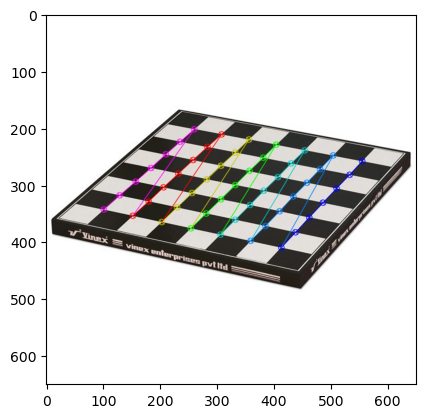

In [83]:
# Printing the detected corners of chessboard
plt.imshow(img)

### Performing camera calibration and storing the .npz

In [84]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

np.savez('B.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)
print("Camera calibration complete. Saved as B.npz")

Camera calibration complete. Saved as B.npz


### Rendering the 3D object on top of the identified chessboard plane

In [85]:
# Loading the camera calibration
with np.load('B.npz') as X:
    mtx, dist, _, _ = [X[i] for i in ('mtx','dist','rvecs','tvecs')]

In [86]:
img = cv.imread('image.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

chessboard_size = (7, 7)
square_size = 2.5

# Defining 3D object points for the chessboard
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp *= square_size  # Scale by square size

In [87]:
def draw_cube(img, imgpts):
    for i, j in zip([0, 1, 2, 3], [1, 2, 3, 0]):
        cv.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (0, 255, 0), 3)

    # Top square
    for i, j in zip([4, 5, 6, 7], [5, 6, 7, 4]):
        cv.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (0, 0, 255), 3)

    # Connecting Base and the Top
    for i in range(4):
        cv.line(img, tuple(imgpts[i]), tuple(imgpts[i + 4]), (255, 0, 0), 3)
    
    return img

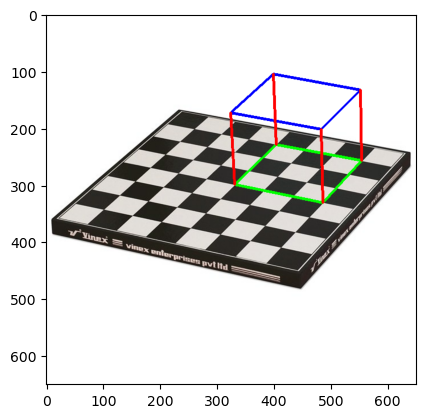

In [88]:
ret, corners = cv.findChessboardCorners(gray, chessboard_size, None)

if ret:
    corners = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), 
                              (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001))

    ret, rvecs, tvecs = cv.solvePnP(objp, corners, mtx, dist)

    cube_size = 3*square_size
    
    cube_points = np.array([
        [0, 0, 0], [0, cube_size, 0], [cube_size, cube_size, 0], [cube_size, 0, 0],  # Bottom square
        [0, 0, -cube_size], [0, cube_size, -cube_size], [cube_size, cube_size, -cube_size], [cube_size, 0, -cube_size]  # Top square
    ], dtype=np.float32)

    # Projecting 3D cube points onto the 2D image
    imgpts, _ = cv.projectPoints(cube_points, rvecs, tvecs, mtx, dist)

    # Converting projected points to integer
    imgpts = np.int32(imgpts).reshape(-1, 2)

    drawn_img = draw_cube(img, imgpts)
    plt.imshow(drawn_img)
else:
    print("Chessboard corners not detected!")